# Analysis notebook for GPI 2.0 APLC solutions 

In [ ]:
import sys
import os

In [1]:
from aplc_optimization.survey import DesignParameterSurvey
import numpy as np
from hcipy import *
from aplc_optimization.analysis import create_coronagraph
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
%pylab inline 
import gpipsfs
import webbpsf
webbpsf.setup_logging('none')
path = '/user/bnickson/aplc-optimization'
import asdf

Populating the interactive namespace from numpy and matplotlib
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-031 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-034
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


Convinience functions:

In [19]:
print(np.linspace(-0.4 / 2, 0.4 / 2, 5) +1 )

[0.8 0.9 1.  1.1 1.2]


# Specify survey(s) and solution(s) for analysis
Provide the name of the survey(s) and particular solution(s) you would like to perform analysis on:

In [2]:
survey_name = 'gpi_2_aplc_c8_iwa34_fpmK1_N0512_telserv3'
solution_filename = '0_GPI_N512_FPM347M0512_IWA0300_OWA02200_C8_BW20_Nlam3_LS_ID04_ov_ODp01__ls_truts_no_tab.fits'
solution = path+'/surveys/'+survey_name+'/solutions/'+solution_filename #solution path

Initiate coronagraph object:

In [3]:
pupil, apodizer, focal_plane_mask, lyot_stops, parameters, file_organization = create_coronagraph(solution)

In [38]:
#Extract some information for later
npix = parameters['pupil']['N']
iwa = parameters['image']['iwa']
owa = parameters['image']['owa']
bandwidth = parameters['image']['bandwidth']
radius_fpm = parameters['focal_plane_mask']['radius']
contrast = parameters['image']['contrast']
ls_alignment_tolerance = parameters['lyot_stop']['alignment_tolerance']
ls_fname = parameters['lyot_stop']['filename']
pupil_fname = parameters['pupil']['filename']
lyot_stop = lyot_stops[0]
lyot_name = (ls_fname.split("_", 4))
lyot_name = 'GPI Lyot '+lyot_name[2]+'_'+lyot_name[3]

In [39]:
ls_alignment_tolerance

0

Let's take a look at the input and output masks

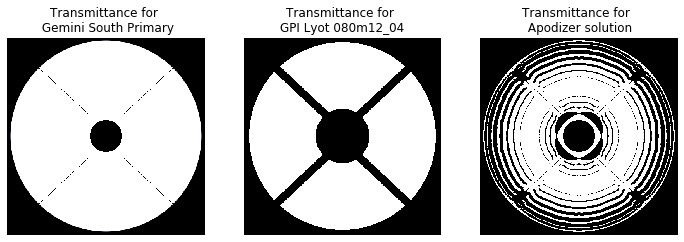

In [5]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title('Transmittance for \n Gemini South Primary')
plt.axis('off')
imshow_field(pupil, cmap='bone')
plt.subplot(1,3,2)
plt.title('Transmittance for \n'+lyot_name)
plt.axis('off')
imshow_field(lyot_stop, cmap='gray')
plt.subplot(1,3,3)
plt.title('Transmittance for \n Apodizer solution')
plt.axis('off')
imshow_field(apodizer, cmap='gray')

And now lets compare with gpipsfs.


In [6]:
# Set up a GPI simulator instance with that apodizer and with the primary and Lyot stop adjusted to be symmetric
gpi = gpipsfs.GPI(custom_apodizer_path=solution,  npix=npix, display_before=False, lyot_tabs=False, force_symmetric_primary = False)
gpi.options['output_mode'] = 'oversampled' # return oversampled arrays (rather than binning to IFS resolution)
oversampling=4

Compute the wavelength for which the ratio of FPM diameter / lambda/D is precisely consistent with the APLC design code.



In [7]:
fpm_r = gpipsfs.GPI_FPM("H").radius*u.milliarcsecond
d_pri = gpipsfs.GeminiPrimary.primary_diameter*u.m
apod_header = fits.getheader(solution)
fpm_in_lambdaD = apod_header['FPM_RAD']

ref_wavelen = (fpm_r.to_value(u.radian)*d_pri / fpm_in_lambdaD).to_value(u.m)

print(f"APLC design optimized for FPM = {fpm_in_lambdaD} lam/D. For the GPI H FPM, that equality is true at {ref_wavelen*1e6:.3f} microns")

APLC design optimized for FPM = 3.476449131 lam/D. For the GPI H FPM, that equality is true at 1.325 microns


------------------------------

# Analysis

## 1.0 Contrast

In [8]:
iwa, owa, contrast, radius_fpm = parameters['image']['iwa'], parameters['image']['owa'], parameters['image']['contrast'], parameters['focal_plane_mask']['radius']

coro = LyotCoronagraph(pupil.grid, focal_plane_mask, lyot_stop)
focal_grid = make_focal_grid(8, owa * 1.2)                       
prop = FraunhoferPropagator(pupil.grid, focal_grid)               
wf = Wavefront(pupil * apodizer)
img = prop(coro(wf)).intensity
img_ref = prop(Wavefront(apodizer * lyot_stop)).intensity
r, profile, std_profile, n_profile = radial_profile(img / max(img_ref), 0.2)

Text(0.5, 0, 'Angular separation ($\\lambda_0/D$)')

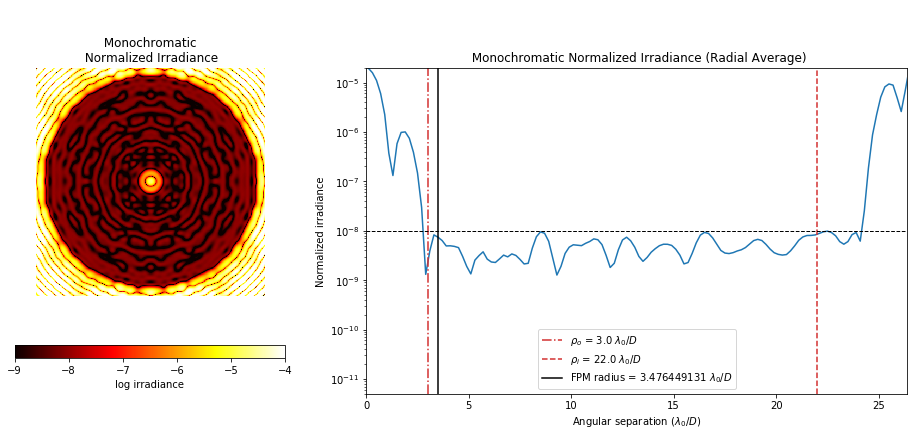

In [19]:
plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
plt.subplot(gs[0])
plt.title('\n\n Monochromatic \n Normalized Irradiance', fontsize=12)
imshow_field(np.log10(img / max(img_ref)), vmin=-contrast - 1, vmax=-contrast + 4, cmap='hot')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('log irradiance')
plt.axis('off')
#plt.xlabel('Angular coordinate ($\lambda_0/D$)', fontsize=14)
#plt.ylabel('Angular coordinate ($\lambda_0/D$)', fontsize=14)
plt.tick_params(axis='both', labelsize=8)
plt.subplot(gs[1])
plt.title('\n Monochromatic Normalized Irradiance (Radial Average)')
plt.plot(r, profile)
iwa_line = plt.axvline(iwa, color=colors.red, linestyle = '-.')
owa_line = plt.axvline(owa, color=colors.red, linestyle = '--')
radius_line = plt.axvline(radius_fpm, color='k')
plt.axhline(10 ** (-contrast), xmin=0, xmax=owa * 1.2, linewidth=1, color='k', linestyle='--')
plt.legend([iwa_line, owa_line, radius_line],
               [r'$\rho_o$ = '+str(float(iwa))+r' $\lambda_0/D$', r'$\rho_i$ = '+str(float(owa))+r' $\lambda_0/D$',
                'FPM radius = '+str(float(radius_fpm))+r' $\lambda_0/D$'])


plt.yscale('log')
plt.xlim(0, owa * 1.2)
plt.ylim(5e-12, 2e-5)
plt.ylabel('Normalized irradiance')
plt.xlabel(r'Angular separation ($\lambda_0/D$)')

------------
# 3.0  Lyot Robustness

Here we introduce robust (tolerant to Lyot stop misalignment) solution to compare the difference in PSFs when Lyot stop misalignment is introduced.

In [20]:
robust_survey_name = 'gpi_fpmK1_robust_5px_5ls_N0512_telserv3'
robust_solution_filename = '0_GPI_N512_FPM347M0512_IWA0300_OWA02200_C8_BW20_Nlam3_LS_ID04_ov_ODp01__ls_truts_no_tab.fits'
robust_solution = path+'/surveys/'+robust_survey_name+'/solutions/'+robust_solution_filename #solution path

robust_pupil, robust_apodizer, robust_focal_plane_mask, robust_lyot_stops, robust_parameters, robust_file_organization = create_coronagraph(robust_solution)
robust_lyot_stop = robust_lyot_stops[0]

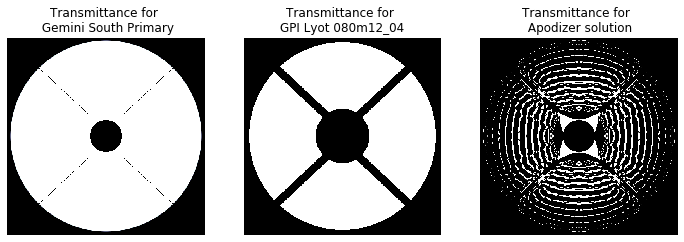

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title('Transmittance for \n Gemini South Primary')
plt.axis('off')
imshow_field(robust_pupil, cmap='bone')
plt.subplot(1,3,2)
plt.title('Transmittance for \n'+lyot_name)
plt.axis('off')
imshow_field(robust_lyot_stop, cmap='gray')
plt.subplot(1,3,3)
plt.title('Transmittance for \n Apodizer solution')
plt.axis('off')
imshow_field(robust_apodizer, cmap='gray')

Text(0.5, 0, 'Angular separation ($\\lambda_0/D$)')

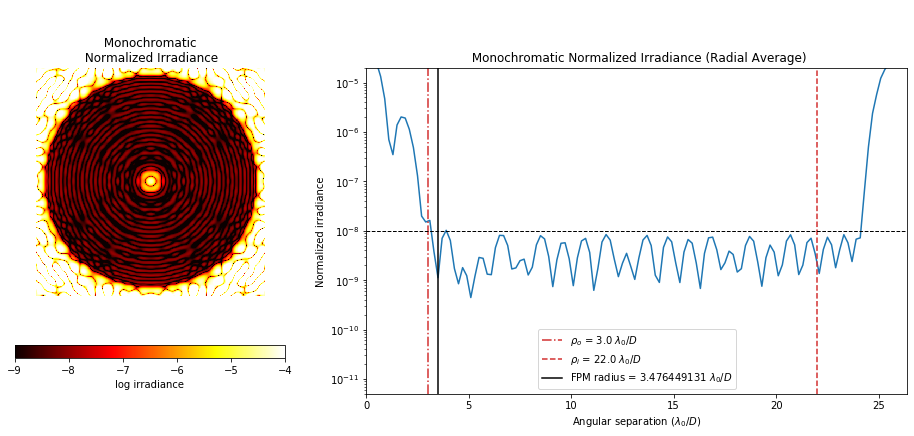

In [51]:
robust_iwa, robust_owa, robust_contrast, robust_radius_fpm = robust_parameters['image']['iwa'], robust_parameters['image']['owa'], robust_parameters['image']['contrast'], robust_parameters['focal_plane_mask']['radius']

robust_coro = LyotCoronagraph(robust_pupil.grid, robust_focal_plane_mask, robust_lyot_stop)
robust_focal_grid = make_focal_grid(8, robust_owa * 1.2)                       
robust_prop = FraunhoferPropagator(robust_pupil.grid, robust_focal_grid)               
robust_wf = Wavefront(robust_pupil * robust_apodizer)
robust_img = robust_prop(robust_coro(robust_wf)).intensity
robust_img_ref = robust_prop(Wavefront(robust_apodizer * robust_lyot_stop)).intensity
robust_r, robust_profile, robust_std_profile, robust_n_profile = radial_profile(robust_img / max(robust_img_ref), 0.2)

plt.figure(figsize=(16,6))
robust_gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
plt.subplot(robust_gs[0])
plt.title('\n\n Monochromatic \n Normalized Irradiance', fontsize=12)
imshow_field(np.log10(robust_img / max(robust_img_ref)), vmin=-contrast - 1, vmax=-contrast + 4, cmap='hot')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('log irradiance')
plt.axis('off')
#plt.xlabel('Angular coordinate ($\lambda_0/D$)', fontsize=14)
#plt.ylabel('Angular coordinate ($\lambda_0/D$)', fontsize=14)
plt.tick_params(axis='both', labelsize=8)
plt.subplot(gs[1])
plt.title('\n Monochromatic Normalized Irradiance (Radial Average)')
plt.plot(robust_r, robust_profile)
robust_iwa_line = plt.axvline(robust_iwa, color=colors.red, linestyle = '-.')
robust_owa_line = plt.axvline(robust_owa, color=colors.red, linestyle = '--')
robust_radius_line = plt.axvline(robust_radius_fpm, color='k')
plt.axhline(10 ** (-robust_contrast), xmin=0, xmax=robust_owa * 1.2, linewidth=1, color='k', linestyle='--')
plt.legend([robust_iwa_line, robust_owa_line, robust_radius_line],
               [r'$\rho_o$ = '+str(float(robust_iwa))+r' $\lambda_0/D$', r'$\rho_i$ = '+str(float(robust_owa))+r' $\lambda_0/D$',
                'FPM radius = '+str(float(robust_radius_fpm))+r' $\lambda_0/D$'])


plt.yscale('log')
plt.xlim(0, robust_owa * 1.2)
plt.ylim(5e-12, 2e-5)
plt.ylabel('Normalized irradiance')
plt.xlabel(r'Angular separation ($\lambda_0/D$)')

In [23]:
rob_ls_align_tol = robust_parameters['lyot_stop']['alignment_tolerance']

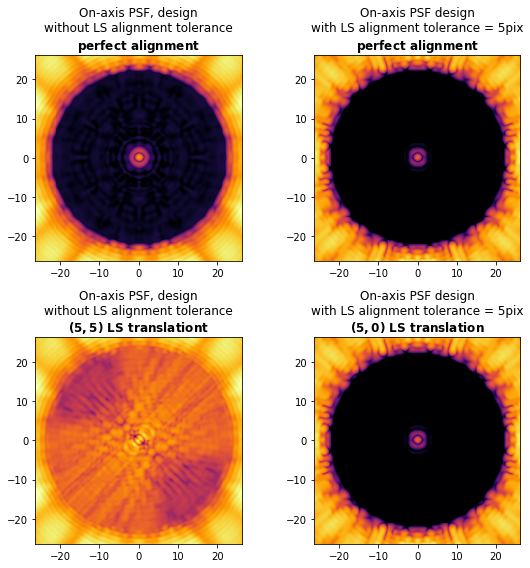

In [55]:
wavelengths = np.linspace(-bandwidth / 2, bandwidth / 2, 11) + 1
dx = 5 # x translation in pixels
dy = 5 # y translation in pixels

focal_grid = make_focal_grid(8, owa * 1.2)
robust_focal_grid = make_focal_grid(8, robust_owa * 1.2)

prop = FraunhoferPropagator(pupil.grid, focal_grid)
robust_prop = FraunhoferPropagator(robust_pupil.grid, robust_focal_grid)

aligned_lyot_stop = np.roll(np.roll(lyot_stop.shaped, 0, 1), 0, 0).ravel()
robust_aligned_lyot_stop = np.roll(np.roll(robust_lyot_stop.shaped, 0, 1), 0, 0).ravel()

shifted_lyot_stop = np.roll(np.roll(lyot_stop.shaped, dx, 1), dy, 0).ravel()
robust_shifted_lyot_stop = np.roll(np.roll(robust_lyot_stop.shaped, dx, 1), 0, 0).ravel()

aligned_coro = LyotCoronagraph(pupil.grid, focal_plane_mask, aligned_lyot_stop)
robust_aligned_coro = LyotCoronagraph(robust_pupil.grid, robust_focal_plane_mask, robust_aligned_lyot_stop)

shifted_coro = LyotCoronagraph(pupil.grid, focal_plane_mask, shifted_lyot_stop)
robust_shifted_coro = LyotCoronagraph(robust_pupil.grid, robust_focal_plane_mask, robust_shifted_lyot_stop)

on_img = 0
off_img = 0
on_robust_img = 0 
off_robust_img = 0 
on_img_ref = 0
off_img_ref = 0
on_robust_img_ref = 0 
off_robust_img_ref = 0 

for wl in wavelengths:
    wf = Wavefront(pupil * apodizer, wl)
    robust_wf = Wavefront(robust_pupil * robust_apodizer, wl)
    
    on_img += prop(aligned_coro(wf)).intensity
    off_img += prop(shifted_coro(wf)).intensity
    
    on_robust_img += robust_prop(robust_aligned_coro(robust_wf)).intensity
    off_robust_img += robust_prop(robust_shifted_coro(robust_wf)).intensity
    
    on_img_ref += prop(Wavefront(pupil * aligned_lyot_stop)).intensity
    off_img_ref += prop(Wavefront(pupil * shifted_lyot_stop)).intensity
    
    on_robust_img_ref += robust_prop(Wavefront(robust_pupil * robust_aligned_lyot_stop)).intensity
    off_robust_img_ref += robust_prop(Wavefront(robust_pupil * robust_shifted_lyot_stop)).intensity
    

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.title('On-axis PSF, design\nwithout LS alignment tolerance\n'+ r'$\bf{perfect \ alignment}$')
imshow_field(np.log10(on_img / max(on_img_ref)), vmin=-contrast - 1, vmax=-contrast + 4, cmap='inferno')
plt.subplot(2,2,2)
plt.title('On-axis PSF design\nwith LS alignment tolerance = '+str(rob_ls_align_tol)+'pix\n'+r'$\bf{perfect \ alignment}$')
imshow_field(np.log10(on_robust_img / max(on_robust_img_ref)), vmin=-robust_contrast - 1, vmax=-robust_contrast + 4, cmap='inferno')
plt.subplot(2,2,3)
plt.title('On-axis PSF, design\nwithout LS alignment tolerance\n'+ r'$\bf{('+str(dx)+','+str(dy)+') \ LS \ translationt}$')
imshow_field(np.log10(off_img / max(off_img_ref)), vmin=-contrast - 1, vmax=-contrast + 4, cmap='inferno')
plt.subplot(2,2,4)
plt.title('On-axis PSF design\nwith LS alignment tolerance = '+str(rob_ls_align_tol)+'pix\n'+ r'$\bf{('+str(dx)+','+str(0)+') \ LS \ translation}$')
imshow_field(np.log10(off_robust_img / max(off_robust_img_ref)), vmin=- robust_contrast - 1, vmax=-robust_contrast + 4, cmap='inferno')
plt.tight_layout()

Text(0.5, 0, 'Angular separation ($\\lambda_0/D$)')

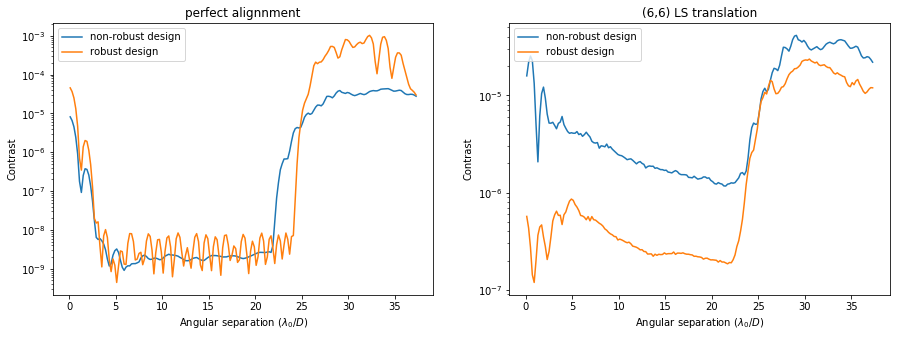

In [52]:
r, profile, std_profile, n_profile = radial_profile(on_img / max(on_img_ref), 0.2)
robust_r, robust_profile, robust_std_profile, robust_n_profile = radial_profile(robust_img / max(robust_img_ref), 0.2)
off_r, off_profile, off_std_profile, off_n_profile = radial_profile(off_img / max(off_img_ref), 0.2)
off_robust_r, off_robust_profile, off_robust_std_profile, off_robust_n_profile = radial_profile(off_robust_img / max(off_robust_img_ref), 0.2)

plt.figure(figsize=(15,5))
#plt.title('\n Monochromatic Normalized Irradiance (Radial Average)')
plt.subplot(1,2,1)
plt.title('perfect alignnment')
plt.plot(r, profile)
plt.plot(robust_r, robust_profile)
plt.legend(['non-robust design','robust design','red'], loc='upper left')
plt.yscale('log')
#plt.xlim(0, owa * 1.2)
#plt.ylim(5e-12, 2e-5)
plt.ylabel('Contrast')
plt.xlabel(r'Angular separation ($\lambda_0/D$)')

plt.subplot(1,2,2)
plt.title('('+str(dx)+','+str(dy)+') LS translation')
plt.plot(off_r, off_profile)
plt.plot(off_robust_r, off_robust_profile)
plt.legend(['non-robust design','robust design','red'], loc='upper left')
plt.yscale('log')
#plt.xlim(0, owa * 1.2)
#plt.ylim(5e-12, 2e-5)
plt.ylabel('Contrast')
plt.xlabel(r'Angular separation ($\lambda_0/D$)')

In [26]:
dx = 5 # x translation in pixels
dy = 5 # y translation in pixels
shifted_lyot_stop = np.roll(np.roll(lyot_stop.shaped, dx, 1), dy, 0).ravel()
coro = LyotCoronagraph(pupil.grid, focal_plane_mask, shifted_lyot_stop)

Text(0.5, 1.0, 'Non-robust solution off-axis PSFs \n')

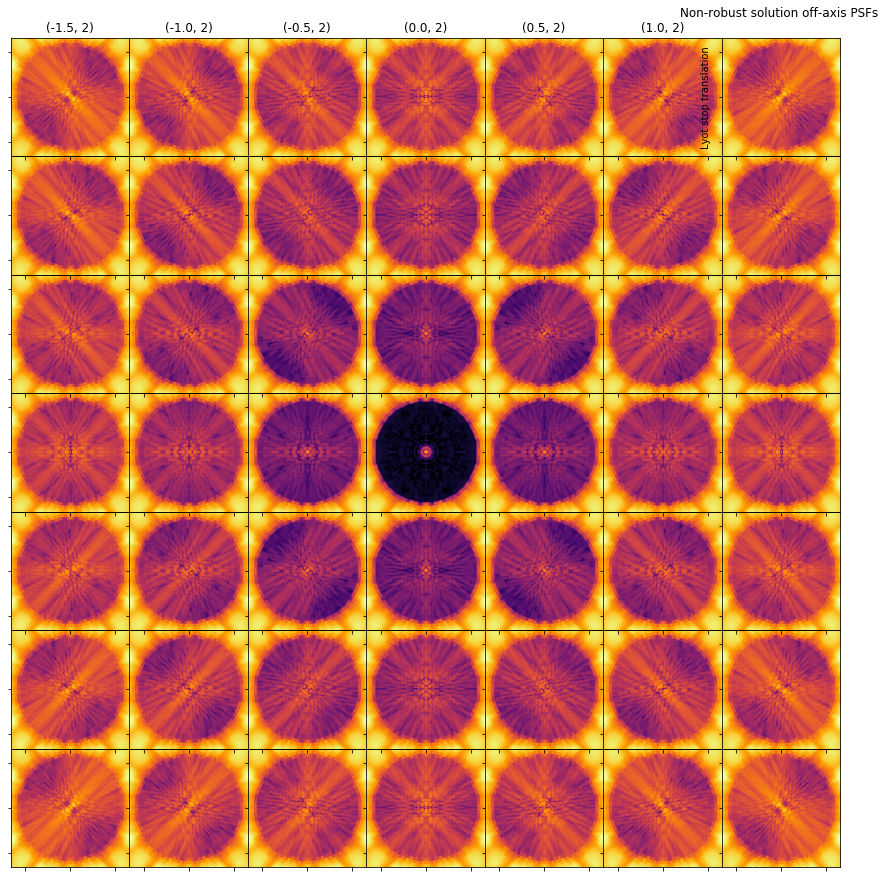

In [42]:
ls_alignment_tolerance = 5 #pixels
dxs = np.array([-3, -2, -1, 0, 1, 2, 3])
dither_grid = CartesianGrid(SeparatedCoords((dxs, dxs)))

plt.figure(figsize=(12, 12))
for i, (dx, dy) in enumerate(dither_grid.points):
    shifted_lyot_stop = np.roll(np.roll(lyot_stop.shaped, dx, 1), dy, 0).ravel()
    coro = LyotCoronagraph(pupil.grid, focal_plane_mask, shifted_lyot_stop)

    img = 0
    img_ref = 0
    
    for wl in wavelengths:
        wf = Wavefront(pupil * apodizer, wl)
        img += prop(coro(wf)).intensity
        img_ref += prop(Wavefront(pupil * lyot_stop)).intensity
        
    x = i % len(dxs)
    y = i // len(dxs)

    plt.subplot(len(dxs), len(dxs), x + (len(dxs) - y - 1) * len(dxs) + 1)
    plt.title('('+str(dx/2)+', '+str(dy-1)+')')
    imshow_field(np.log10(img / max(img_ref)), vmin=-contrast - 1, vmax=-contrast + 4, cmap='inferno')

    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

plt.subplots_adjust(top=0.98, bottom=0.02, left=0.02, right=0.98, wspace=0, hspace=0)
plt.ylabel('Lyot stop translation')
plt.title('Non-robust solution off-axis PSFs \n')

Text(0.5, 1.0, 'Non-robust solution off-axis PSFs \n')

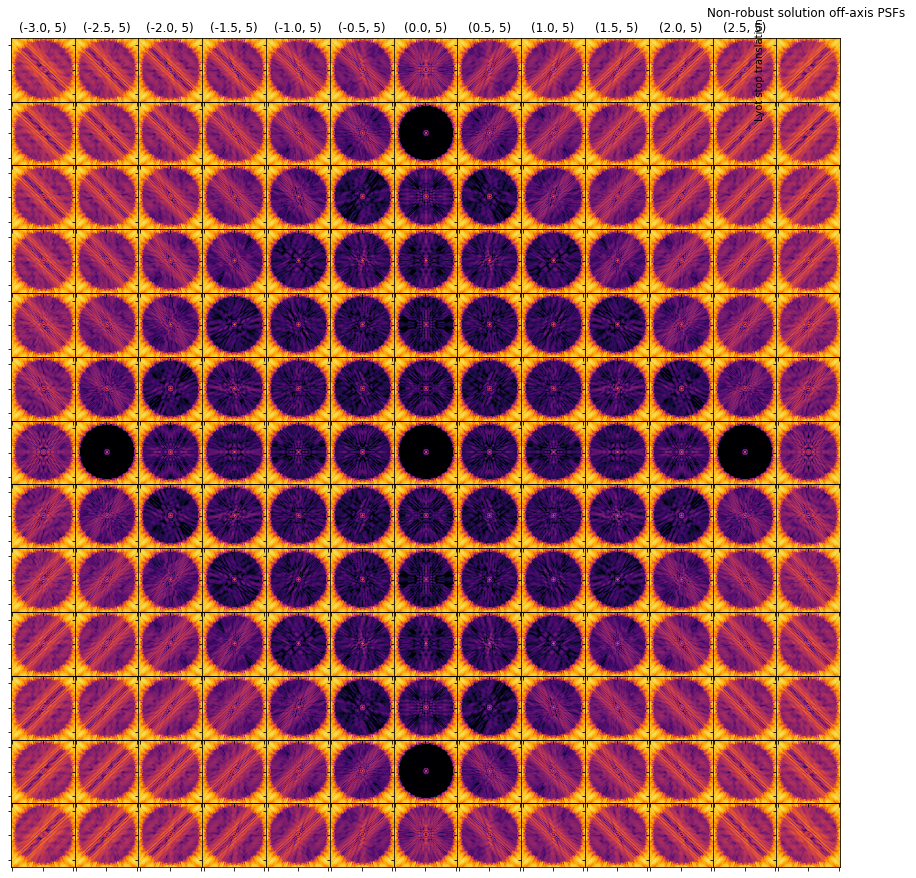

In [45]:
robust_ls_alignment_tolerance = robust_parameters['lyot_stop']['alignment_tolerance']
dxs = np.array(range(-robust_ls_alignment_tolerance-1,+robust_ls_alignment_tolerance+1+1,1))

dither_grid = CartesianGrid(SeparatedCoords((dxs, dxs)))

plt.figure(figsize=(12, 12))
for i, (dx, dy) in enumerate(dither_grid.points):
    robust_shifted_lyot_stop = np.roll(np.roll(robust_lyot_stop.shaped, dx, 1), dy, 0).ravel()
    robust_coro = LyotCoronagraph(robust_pupil.grid, robust_focal_plane_mask, robust_shifted_lyot_stop)

    robust_img = 0
    robust_img_ref = 0
    
    for wl in wavelengths:
        wf = Wavefront(robust_pupil * robust_apodizer, wl)
        robust_img += robust_prop(robust_coro(wf)).intensity
        robust_img_ref += robust_prop(Wavefront(robust_pupil * robust_lyot_stop)).intensity
        
    x = i % len(dxs)
    y = i // len(dxs)

    plt.subplot(len(dxs), len(dxs), x + (len(dxs) - y - 1) * len(dxs) + 1)
    plt.title('('+str(dx/2)+', '+str(dy-1)+')')
    imshow_field(np.log10(robust_img / max(robust_img_ref)), vmin=-robust_contrast - 1, vmax=-robust_contrast + 4, cmap='inferno')

    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

plt.subplots_adjust(top=0.98, bottom=0.02, left=0.02, right=0.98, wspace=0, hspace=0)
plt.ylabel('Lyot stop translation')
plt.title('Non-robust solution off-axis PSFs \n')

In [41]:
ls_alignment_tolerance

0

In [48]:
np.array(range(-ls_alignment_tolerance-1,+ls_alignment_tolerance+1+1,1))

array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6])

In [49]:
robust_radius_fpm = robust_parameters['focal_plane_mask']['radius']

In [50]:
robust_radius_fpm

3.476449131